# Placement

This is based on the work of "Architecture-aware FPGA placement using metric embedding"
The objective for a metric based placement will be: $||D_DP-PD_A||_F^2$ where P is the permutation matrix and D_x is the distance matrix.
The constraints on permutation matrix are: $\sum_{i=1}^n P(i,j) = 1, \forall j$ 

and $\sum_{j=1}^n P(i,j) = 1, \forall i$

Casting the placement into QUBO:

-objective
$f=\sum_I^n\sum_J^n\{-2D_{II}A_{JJ}x_{IJ}+\sum_i^n[D_{Ii}^2x_{iJ}+A_{iJ}^2x_{Ii}+\sum_{j\neq i}^n (D_{Ii}D_{Ij}x_{iJ}x_{jJ}+A_{iJ}A_{jJ}x_{Ii}x_{Ij})]-\sum_{i\neq I}^n\sum_{j\neq J}^n[A_{jJ}D_{Ii}x_{iJ}x_{Ij}]-\sum_{i\neq J}^n\sum_{j\neq I}^n[A_{iJ}D_{Ij}x_{Ii}x_{jJ}]\}$

-constraint on row and columns separately (in case we need to relax one):
$\sum_j^n [1-\sum_i^nx_{ij}]^2=\sum_j^n\sum_i^n[-x_{ij}+2\sum_{k\neq i}^nx_{ij}x_{kj}]$

$\sum_i^n [1-\sum_j^nx_{ij}]^2=\sum_i^n\sum_j^n[-x_{ij}+2\sum_{k\neq j}^nx_{ij}x_{ik}]$

In [1]:
#distance matrix calculator

In [2]:
from essentials import *
from itertools import product as prd

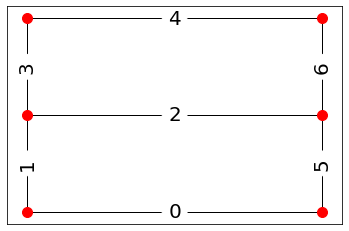

In [4]:
G = RectGridGraph(2, 3)
G.draw()

In [5]:
D_D = np.array([[0, 2, 2, 1, 2, 2], [2, 0, 2, 1, 2, 2], [2, 2, 0, 1, 2, 2], [1, 1, 1, 0, 1, 1],[2, 2, 2, 1, 0, 2],[2, 2, 2, 1, 2, 0]])
D_A = np.array([[0, 1, 1, 2, 2, 3], [1, 0, 2, 1, 3, 2], [1, 2, 0, 1, 1, 2], [2, 1, 1, 0, 2, 1],[2, 3, 1, 2, 0, 1],[3, 2, 2, 1, 1, 0]])

In [6]:
def set_qubo_val(Q, x1, x2, value):
    if (x1, x2) in Q.keys():
        Q[(x1, x2)] += value
    elif (x2, x1) in Q.keys():
        Q[(x2, x1)] += value
    else:
        raise Exception('Your key is not in the Q dict.') 
        
def placement_qubo(D_design, D_architecture, params={'weight_objective': 1, 'weight_row': 1, 'weight_column': 1}):
    #D_design and D_architecture matrices are 2-D numpy arrays
    Q = {}
    n = len(D_design)
    D = D_design
    A = D_architecture
    # for now the design and architecture distance matrices are of the same size
    
    permutation_matrix_elements=[]
    for var1, var2 in prd(range(0, n), repeat=2):
        permutation_matrix_elements.append([var1, var2])
        
    for var1, var2 in cwr(permutation_matrix_elements, 2):
            Q[(f'x{var1[0]}{var1[1]}', f'x{var2[0]}{var2[1]}')] = 0
    
    # Objective
    w1 = params['weight_objective']
    for I, J in prd(range(0,n), repeat=2):
        Q[(f'x{I}{J}', f'x{I}{J}')] += w1 * -2 * D[I][I] * A[J][J]
        for i in range(0,n):
            Q[(f'x{i}{J}', f'x{i}{J}')] += w1 * D[I][i]^2
            Q[(f'x{I}{i}', f'x{I}{i}')] += w1 * A[i][J]^2
            for j in range(0,n):
                if i != j:
                    set_qubo_val(Q, f'x{i}{J}', f'x{j}{J}', w1 * D[I][i] * D[I][j])
                    set_qubo_val(Q, f'x{I}{i}', f'x{I}{j}', w1 * A[i][J] * A[j][J])
        for i, j in prd(range(0,n), repeat=2):
            if i != I and j != J:
                set_qubo_val(Q, f'x{i}{J}', f'x{I}{j}', -w1 * A[j][J] * D[I][i])
            if i != J and j != I:
                set_qubo_val(Q, f'x{I}{i}', f'x{j}{J}', -w1 * A[i][J] * D[I][j])

    #constraint on rows
    w2 = params['weight_row']
    for i, j in prd(range(0, n), repeat=2):
        Q[(f'x{i}{j}', f'x{i}{j}')] += w2 * -1
        for k in range(0, n):
            if k != i:
                set_qubo_val(Q, f'x{i}{j}', f'x{k}{j}', w2 * 2)
    
    #constraint on columns
    w3 = params['weight_column']
    for i, j in prd(range(0, n), repeat=2):
        Q[(f'x{i}{j}', f'x{i}{j}')] += w3 * -1
        for k in range(0, n):
            if k != j:
                set_qubo_val(Q, f'x{i}{j}', f'x{i}{k}', w3 * 2) 
    return Q

In [7]:
Q=placement_qubo(D_A, D_D)
dwave_sampler = DWaveSampler(solver={'lower_noise': True, 'qpu': True})
A = dwave_sampler.edgelist
embedding, chain_len = find_embedding_minorminer(Q, A)
## the shortest chain_len I've seen with num_tries=1000 is 5
## (SP: takes 2.5 mins on my machine, SAS: 1:08 on mine)
display(chain_len)

13

/home/sarashs/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/sarashs/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/sarashs/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


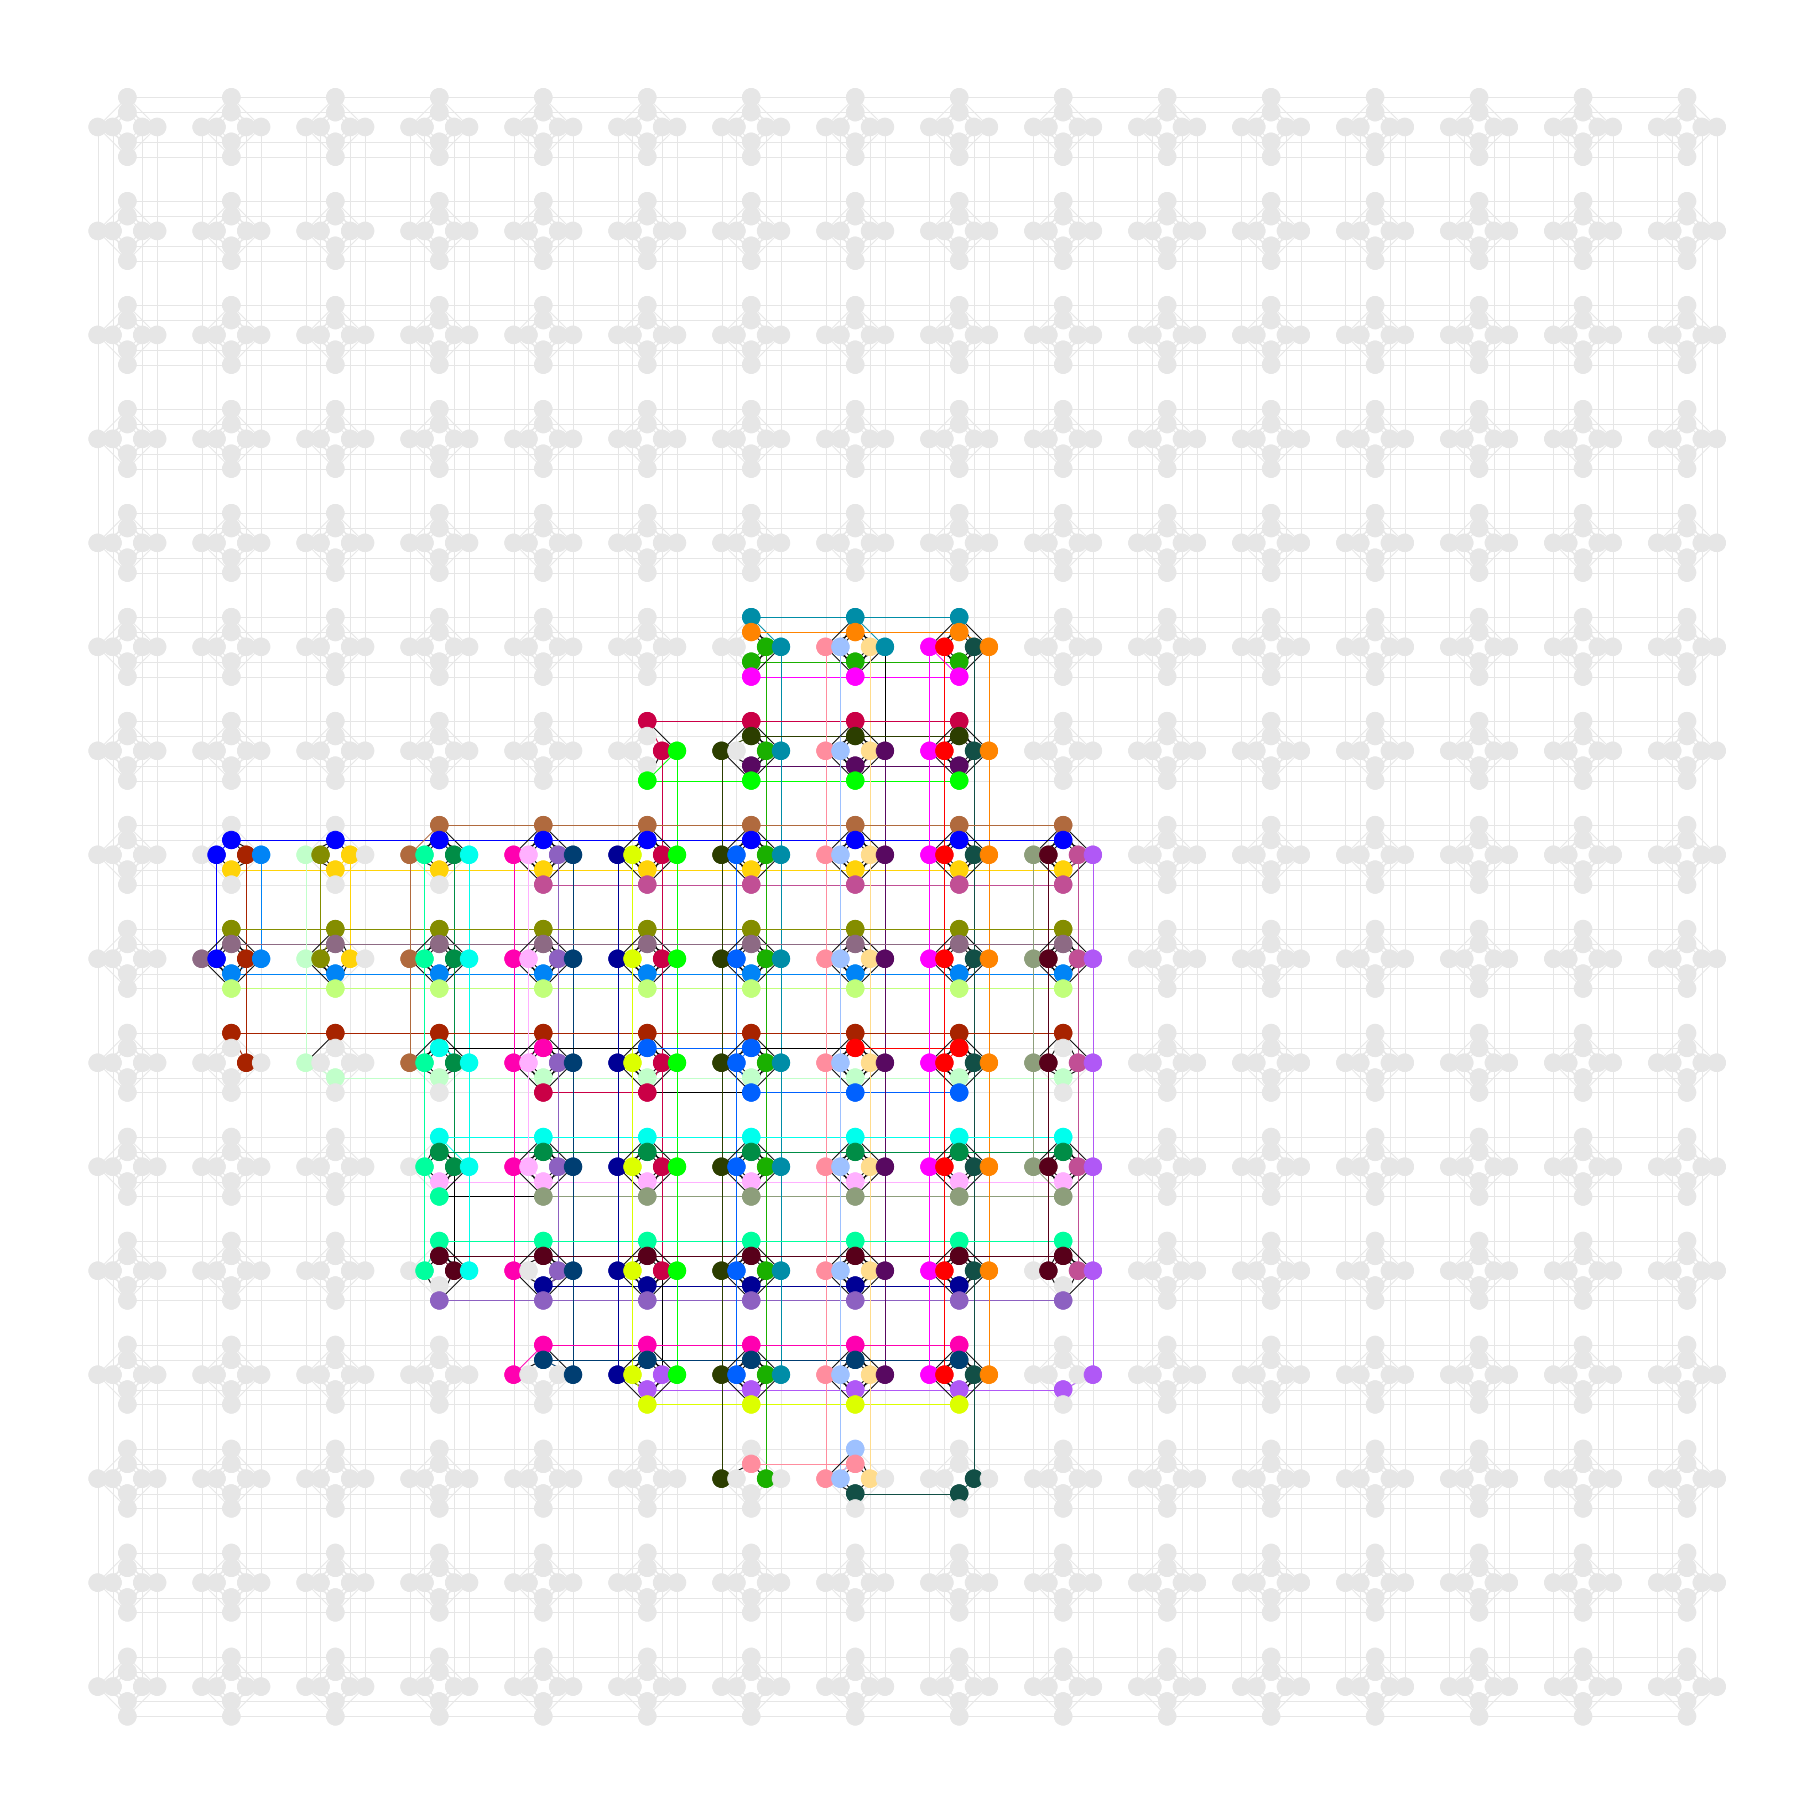

In [8]:
connectivity_structure = dnx.chimera_graph(16,16)
fig=plt.figure(figsize=(25, 25))
dnx.draw_chimera_embedding(connectivity_structure, embedding)

In [13]:
fixed_sampler = FixedEmbeddingComposite(
            DWaveSampler(solver={'lower_noise': True, 'qpu': True}), embedding
            )
response = optimize_qannealer(fixed_sampler, Q, params={'chain_strength': 20, 'annealing_time': 99, 'num_reads': 10000})
display(response.first)
best_q_answer = response.first.sample

Sample(sample={'x00': 0, 'x01': 1, 'x02': 1, 'x03': 1, 'x04': 0, 'x05': 0, 'x10': 1, 'x11': 0, 'x12': 0, 'x13': 0, 'x14': 1, 'x15': 1, 'x20': 0, 'x21': 0, 'x22': 1, 'x23': 0, 'x24': 0, 'x25': 1, 'x30': 0, 'x31': 0, 'x32': 0, 'x33': 0, 'x34': 1, 'x35': 1, 'x40': 1, 'x41': 1, 'x42': 1, 'x43': 0, 'x44': 0, 'x45': 0, 'x50': 1, 'x51': 1, 'x52': 0, 'x53': 0, 'x54': 1, 'x55': 0}, energy=-174.0, num_occurrences=1, chain_break_fraction=0.3055555555555556)